<a href="https://colab.research.google.com/github/jhhan0/self-study-ml/blob/main/notes/celeba-cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CelebA Dataset Classifiction using the Convolutional Neural Network

In [12]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 KB 13.5 MB/s eta 0:00:00


In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_cv
import numpy as np
import matplotlib.pyplot as plt

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


Download CelebA Dataset using `tfds.builder()`.

In [2]:
celeba_builder = tfds.builder('celeb_a')
celeba_builder.download_and_prepare()
celeba = celeba_builder.as_dataset(shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteNMINQY/celeb_a-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteNMINQY/celeb_a-validation.tfrecord*...:   0%|     …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteNMINQY/celeb_a-test.tfrecord*...:   0%|          |…

Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


Split CelebA Dataset into `train`, `validation`, and `test` datasets.

In [10]:
train_ds = celeba['train']
val_ds = celeba['validation']
test_ds = celeba['test']

Apply some **data augmentation** methods like horizontal/vertical rotation, bounding-box cropping, and adjusting brightness.

- Using `keras_cv.layers.RandAugment()` layer
- Using custom `tf.image` augmentation

In [28]:
# layers = keras_cv.layers.RandAugment.get_standard_policy(value_range=(0, 1), magnitude=0.1, magnitude_stddev=0.15)
# layers = [layer for layer in layers if not isinstance(layer, keras_cv.layers.RandomBrightness)]
# pipeline = keras_cv.layers.RandomAugmentationPipeline(layers=layers, augmentations_per_image=3)

# def augment(inputs, size=(64, 64), mode='train'):
#   image, label = inputs['image'], inputs['attributes']['Eyeglasses']
#   if mode == 'train':
#     return pipeline(tf.cast(image, tf.float32) / 255.0), tf.cast(label, tf.uint8)
#   # test
#   else:
#     image = tf.image.resize(image, size=size)
#     return tf.cast(image, tf.float32) / 255.0, tf.cast(label, tf.uint8)

In [30]:
def augment(inputs, size=(64, 64), mode='train'):
  image, label = inputs['image'], inputs['attributes']['Eyeglasses']
  if mode == 'train':
    image = tf.image.resize(image, size=size)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_flip_up_down(image)
    return tf.cast(image, tf.float32) / 255.0, tf.cast(label, tf.uint8)
  else:
    image = tf.image.resize(image, size=size)
    return tf.cast(image, tf.float32) / 255.0, tf.cast(label, tf.uint8)

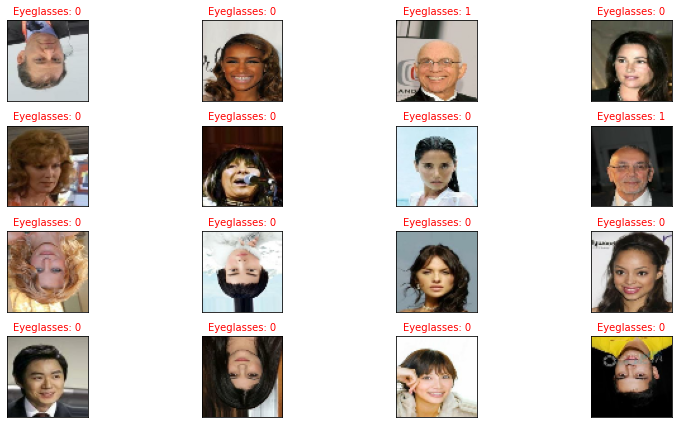

In [33]:
tf.random.set_seed(1)
ds = train_ds.shuffle(100, reshuffle_each_iteration=False)
ds = ds.take(16)
ds = ds.map(lambda x: augment(x))

fig = plt.figure(figsize=(12, 6))
for i, sample in enumerate(ds):
  ax = fig.add_subplot(4, 4, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(sample[0].numpy())
  ax.set_title('Eyeglasses: {}'.format(sample[1]), size=10, color='red')

plt.tight_layout()
plt.show()

In [34]:
BATCH_SIZE = 64
IMAGE_SIZE = (64, 64)
BUFFER_SIZE = 80000

train_ds = train_ds.map(lambda x: augment(x, size=IMAGE_SIZE, mode='train'))
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE).batch(BATCH_SIZE)
val_ds = val_ds.map(lambda x: augment(x, size=IMAGE_SIZE, mode='val')).batch(BATCH_SIZE)

Create CNN model using `tf.keras.Sequential`.

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
])

Add `tf.keras.layers.GlobalAveragePooling2D()` and `tf.keras.layers.Dense()` layers at the end for classification.

In [36]:
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1, activation=None))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

Configure the compile setting and train the CNN model.

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [40]:
history = model.fit(train_ds, epochs=1, validation_data=val_ds)

2544/2544 [==============================] - 121s 47ms/step - loss: 0.1474 - accuracy: 0.9534 - val_loss: 0.0808 - val_accuracy: 0.9710


Save the model using `model.save()`.

In [ ]:
# model.save('celeba-cnn.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [41]:
test_ds = test_ds.map(lambda x: augment(x, size=IMAGE_SIZE, mode='test')).batch(BATCH_SIZE)

In [42]:
results = model.evaluate(test_ds)
print('Test loss: {:.3f}, Test acc: {:.3f}'.format(*results))

312/312 [==============================] - 11s 34ms/step - loss: 0.0714 - accuracy: 0.9761
Test loss: 0.071, Test acc: 0.976


Display 10 CelebA test dataset images with its correct and predicted labels (in this case, it is *Eyeglasses*)

In [43]:
samples = test_ds.unbatch().take(10)

In [44]:
logits = model.predict(samples.batch(1))
probas = np.round(tf.sigmoid(logits).numpy().flatten(), decimals=2)*100
print(probas)

10/10 [==============================] - 1s 10ms/step
[ 0.  4.  0. 68.  0.  3.  0. 99.  1.  1.]


In [46]:
class_labels = ['Wear Eyeglasses', 'No Eyeglasses']

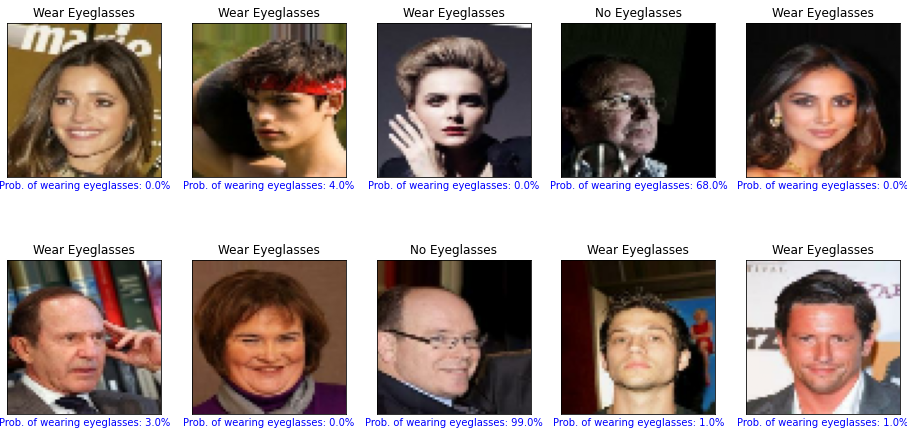

In [47]:
fig = plt.figure(figsize=(16, 8))
for element in samples.enumerate():
  ax = fig.add_subplot(2, 5, element[0].numpy()+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('Prob. of wearing eyeglasses: {}%'.format(probas[element[0].numpy()]), color='blue')
  ax.set_title('{}'.format(class_labels[element[1][1].numpy()]))
  ax.imshow(element[1][0].numpy())
plt.show()